# Targeted particle delivery via ring vortex reconnection
In this notebook, we reproduce all the figures from the paper: 

In [21]:
# Required libraries to run the post-processing script
import sys
import os 
sys.path.append("/home/j/jphickey/josephmo/scratch/pencil-ind/python")
os.environ["PATH"] += os.pathsep +'/home/j/jphickey/josephmo/scratch/pencil-ind/bin'
import math
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import optimize
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

width = 409
nice_fonts = {
  # Use LaTex to write all text
  "text.usetex": True,
  "font.family": "sans-serif",
  "font.serif": "FreeSans",
  # Use 10pt font in plots, to match 10pt font in document
  "axes.labelsize": 9,
  "font.size": 8.5,
  # Make the legend/label fonts a little smaller
  "legend.fontsize": 8,
  "xtick.labelsize": 8.5,
  "ytick.labelsize": 8.5,
}
matplotlib.rcParams.update(nice_fonts)

def set_fig(width, fraction=1,sidebyside=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) 

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio/sidebyside

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

#complete list of all of the cases
fileName={'S01U0':'st01'                ,'S1U0':'st1'                 , 'S10U0':'st10'                ,'S01U10':'st01_backflow_u001',
          'S01U25':'st01_backflow_u0025','S01U50':'st01_backflow_u005', 'S01U75':'st01_backflow_u0075','S1U0G':'st1_gap1'           ,            
          'S1U0G2':'st1_gap2'           ,'S1U05':'st1_backflow_u005'  , 'S1U25':'st1_backflow_u0025'  ,'S1U50':'st1_backflow_u005'  ,
          'S1U75':'st1_backflow_u0075'  ,'S01U0G':'st01_gap1'         , 'S01U0G2':'st01_gap2'         }

colorList=[ 'red', 'green', 'blue','orange','red', 'green', 'blue','orange']
#colorList=[cm.rainbow(x) for x in np.linspace(0, 1, 10)]
lineList = ['-','-','-','-','-.','-.','-.','-.']

In [16]:
# User inputs
tot_tstep = 410
num_part  = 500
dim       =  3
num_cases = len(fileName)

#############################################################################
################### SAVE .PICKLE DATA INTO LOCAL VARIABLES ##################
#############################################################################
time = np.zeros(tot_tstep)

pos    = np.zeros([dim,num_part,tot_tstep,num_cases])
vel    = np.zeros([dim,num_part,tot_tstep,num_cases])
mpos   = np.zeros([dim,tot_tstep,num_cases])
stdpos = np.zeros([dim,tot_tstep,num_cases])
mvel   = np.zeros([dim,tot_tstep,num_cases])

#mapping time to space
nbbins   = 70
bins     = np.linspace(0, 2.8*np.pi, nbbins )
mpos_space= np.zeros([dim,nbbins,num_cases])
stdpos_space= np.zeros([dim,nbbins,num_cases])


timespace   =  [None] * num_cases
time_vs_pos =  [None] * num_cases

masterDict = {}

Xc=0;Yc=1;Zc=2
correct_x = 3.1416

for case_counter,case in enumerate(fileName):
    masterDict[case]=case_counter
    pickle_in=open(fileName[case]+'.pickle','rb')
    data=pickle.load(pickle_in)
    pickle_in.close()
    
    time[:]                   = data['time']
    
    pos[Xc,:,:,case_counter]  = data['part_zp'] + correct_x  #pencil swaps x/z axis
    pos[Yc,:,:,case_counter]  = data['part_yp']
    pos[Zc,:,:,case_counter]  = data['part_xp']
    print(case,min(data['part_zp'].flatten()+ correct_x),max(data['part_zp'].flatten()+ correct_x))
    
    #a few cases loop around, we correct here
    if case in ['S01U50','S01U75','S1U50','S1U75']:
        temp=pos[Xc,:,:,case_counter]
        for tt in range(tot_tstep):
            if min(temp[:,tt])<1 and max(temp[:,tt])>6:
                indexLoop=np.where(pos[Xc,:,tt,case_counter]<1.)
                pos[Xc,indexLoop,tt,case_counter]+=4*np.pi
                
                
    mpos[Xc,:,case_counter]   = np.mean(data['part_zp']+ correct_x,axis=0)
    mpos[Yc,:,case_counter]   = np.mean(abs(data['part_yp']),axis=0)
    mpos[Zc,:,case_counter]   = np.mean(abs(data['part_xp']),axis=0)
    
    stdpos[Xc,:,case_counter] = np.std(data['part_zp']+ correct_x,axis=0)
    stdpos[Yc,:,case_counter] = np.std(abs(data['part_yp']),axis=0)
    stdpos[Zc,:,case_counter] = np.std(abs(data['part_xp']),axis=0)
    
    timespace[case_counter] = interp1d(time[:], mpos[Xc,:,case_counter])
    
    inds = np.digitize(pos[Xc,:,:,case_counter], bins)
    mpos_space[Xc,:,case_counter] = [np.mean(abs(pos[Xc,inds[:, :] == i,case_counter])) for i in range(len(bins))]
    mpos_space[Yc,:,case_counter] = [np.mean(abs(pos[Yc,inds[:, :] == i,case_counter])) for i in range(len(bins))]   
    mpos_space[Zc,:,case_counter] = [np.mean(abs(pos[Zc,inds[:, :] == i,case_counter])) for i in range(len(bins))]      

    stdpos_space[Xc,:,case_counter] = [np.std(abs(pos[Xc,inds[:, :] == i,case_counter])) for i in range(len(bins))]
    stdpos_space[Yc,:,case_counter] = [np.std(abs(pos[Yc,inds[:, :] == i,case_counter])) for i in range(len(bins))]   
    stdpos_space[Zc,:,case_counter] = [np.std(abs(pos[Zc,inds[:, :] == i,case_counter])) for i in range(len(bins))]  
    
    time_vs_pos[case_counter] = interp1d(time,mpos[Xc,:,case_counter], kind='cubic') #f(time)=average position

S01U0 -0.23591551835604685 6.464875212123481
S1U0 -0.2544834336188089 7.069016365544565
S10U0 -3.042950619916574 7.538711305048643
S01U10 -0.21187012453549636 6.982370955728948
S01U25 -0.17576384211206353 7.753298085021829
S01U50 -0.1157247015705245 9.033005165849385
S01U75 -3.1414601350668145 9.424729573516554
S1U0G -0.05580761683707536 8.807482349217132
S1U0G2 7.346410206832132e-06 9.149921059803958
S1U05 -0.1315381469840795 9.040973564117085
S1U25 -0.1918967086015546 7.796244933185752
S1U50 -0.1315381469840795 9.040973564117085
S1U75 -3.1415373051599356 9.424542717822858
S01U0G -0.019605746829844062 8.204061075956977
S01U0G2 7.346410206832132e-06 8.458451894569949


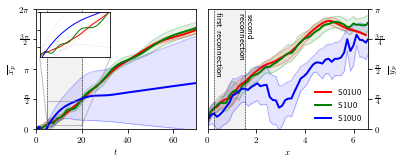

In [19]:
###############################################################################
############ FIGURE 2: PARTICLE MEAN POSITION + STD. DEV. VS. TIME ############
###############################################################################
fig, (ax1, ax2) = plt.subplots(1,2, figsize=set_fig(width,sidebyside=3))

cases=['S01U0','S1U0','S10U0']

ax1.fill_between([5,20],[10,10],
                 facecolor='grey', #fill color
                 color='grey', #outline color
                 alpha=0.1) #fill transparency
ax2.fill_between([time_vs_pos[masterDict[cases[0]]](5),time_vs_pos[masterDict[cases[0]]](20)],[10,10],
                 facecolor='grey', #fill color
                 color='grey', #outline color
                 alpha=0.1) #fill transparency

# time evolution in the x-direction
for jj,case in enumerate(cases):
  ii=masterDict[case]
  ax1.fill_between(time, mpos[Xc,:,ii]+stdpos[Xc,:,ii],mpos[Xc,:,ii]-stdpos[Xc,:,ii],
                 facecolor=colorList[jj], #fill color
                 color=colorList[jj], #outline color
                 alpha=0.1) #fill transparency
  ax1.plot(time, mpos[Xc,:,ii]+stdpos[Xc,:,ii], colorList[jj], alpha=0.5, lw = 0.4 )
  ax1.plot(time, mpos[Xc,:,ii]-stdpos[Xc,:,ii], colorList[jj], alpha=0.5, lw = 0.4 )
  ax1.plot(time, mpos[Xc,:,ii], colorList[jj], lw = 2, label=case)

ax1.axvline(x=5, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax1.axvline(x=20, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$\overline{x_p}$')
ax1.set_xlim(0,time[350])
ax1.set_ylim(0,2*math.pi)
ax1.set_yticks([0, math.pi/2, math.pi, 3*math.pi/2, 2*math.pi])
ax1.set_yticklabels([r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])

#Inset figure
axins = ax1.inset_axes([0.025, 0.6, 0.44, 0.375])
cases_inset=['S01U0','S1U0','S10U0']
for jj,case in enumerate(cases_inset):
  ii=masterDict[case]
  axins.plot(time, mpos[Xc,:,ii]+stdpos[Xc,:,ii], colorList[jj], alpha=0.25, lw = 0.2 )
  axins.plot(time, mpos[Xc,:,ii]-stdpos[Xc,:,ii], colorList[jj], alpha=0.25, lw = 0.2 )
  axins.plot(time, mpos[Xc,:,ii], colorList[jj], lw = 1, label=case)
  
axins.set_xlim(5, 20)
axins.set_ylim(0.2, 1.5)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.set_xticks([])
ax1.indicate_inset_zoom(axins)

#spatial evolution in y
for jj,case in enumerate(cases):
  ii=masterDict[case]
  ax2.fill_between(bins, mpos_space[Yc,:,ii]+stdpos_space[Yc,:,ii],mpos_space[Yc,:,ii]-stdpos_space[Yc,:,ii],
                 facecolor=colorList[jj], #fill color
                 color=colorList[jj], #outline color
                 alpha=0.1) #fill transparency
  ax2.plot(bins, mpos_space[Yc,:,ii]+stdpos_space[Yc,:,ii], colorList[jj], alpha=0.5, lw = 0.4)
  ax2.plot(bins, mpos_space[Yc,:,ii]-stdpos_space[Yc,:,ii], colorList[jj], alpha=0.5, lw = 0.4)
  ax2.plot(bins, mpos_space[Yc,:,ii], colorList[jj], lw = 2, label=case)
  ax2.yaxis.set_label_position("right")
  ax2.yaxis.tick_right()

ax2.axvline(x=time_vs_pos[masterDict[cases[0]]](5), ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax2.axvline(x=time_vs_pos[masterDict[cases[0]]](20), ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$\overline{y_p}$')
ax2.text(0.3,1.4,'first reconnection',rotation=-90)
ax2.text(1.58,2.4,'second',rotation=-90)
ax2.text(1.25,1.85,'reconnection',rotation=-90)
ax2.set_xlim(0,2.1*math.pi)
ax2.set_ylim(0,math.pi)
ax2.set_yticks([0, math.pi/4, math.pi/2, 3*math.pi/4, math.pi])
ax2.set_yticklabels([r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('figure_02.pdf')
plt.show()

4.908383449548951 2.8388935821651864
6.055241782725675 2.8218735968797137
7.202866658358987 2.8011516467249034
8.351099467938065 2.780261949415627


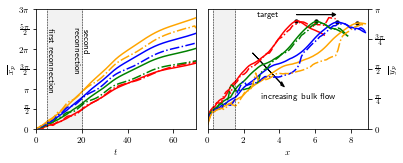

In [22]:
####################################################################################################
###################### FIGURE 4: MEAN y_p & z_p VS. t: ST01 & ST1 CHANNEL FLOW #####################
####################################################################################################
fig, (ax1, ax2) = plt.subplots(1,2, figsize=set_fig(width,sidebyside=3))

ax1.fill_between([5,20],[10,10],
                 facecolor='grey', #fill color
                 color='grey', #outline color
                 alpha=0.1) #fill transparency
ax2.fill_between([time_vs_pos[masterDict[cases[0]]](5),time_vs_pos[masterDict[cases[0]]](20)],[10,10],
                 facecolor='grey', #fill color
                 color='grey', #outline color
                 alpha=0.1) #fill transparency

cases=['S01U0','S01U25','S01U50','S01U75','S1U0','S1U25','S1U50','S1U75']
for jj,case in enumerate(cases):
  ii=masterDict[case]
  ax1.plot(time, mpos[Xc,:,ii], colorList[jj],linestyle=lineList[jj], lw =1.5, label=case)
ax1.axvline(x=5, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax1.axvline(x=20, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$\overline{x_p}$')
ax1.set_xlim(0,time[350])
ax1.set_ylim(0,3*math.pi)
ax1.set_yticks([0, math.pi/2, math.pi, 3*math.pi/2, 2*math.pi, 5*math.pi/2,3*math.pi])
ax1.set_yticklabels([r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$', r'$\frac{5\pi}{2}$', r'$3\pi$'])
ax1.text(5.1,3,'first reconnection',rotation=-90)
ax1.text(20.5,6,'second',rotation=-90)
ax1.text(16.5,4.4,'reconnection',rotation=-90)

for jj,case in enumerate(cases):
  ii=masterDict[case]
  ax2.plot(bins, mpos_space[Yc,:,ii], colorList[jj],linestyle=lineList[jj], lw =1.5, label=case)
  ax2.yaxis.set_label_position("right")
  ax2.yaxis.tick_right()
  if case in ['S01U0','S01U25','S01U50','S01U75']:
    jj=np.nanargmax(mpos_space[Yc,:,ii])
    print(mpos_space[Xc,jj,ii],mpos_space[Yc,jj,ii])
    ax2.scatter(mpos_space[Xc,jj,ii],mpos_space[Yc,jj,ii],c='k',s=11)
    
ax2.axvline(x=time_vs_pos[masterDict[cases[0]]](5), ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax2.axvline(x=time_vs_pos[masterDict[cases[0]]](20), ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$\overline{y_p}$')
ax2.set_xlim(0,2.85*math.pi)
ax2.set_ylim(0,math.pi)
ax2.set_yticks([0, math.pi/4, math.pi/2, 3*math.pi/4, math.pi])
ax2.set_yticklabels([r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])
ax2.arrow(4.95, 3, 2, 0,head_width=0.1, head_length=0.2, fc='k', ec='k')
ax2.arrow(2.5, 2, 1.6, -0.8,head_width=0.1, head_length=0.2, fc='k', ec='k')
ax2.text(2.75,2.95,'target')
ax2.text(3.,0.8,'increasing bulk flow')
#ax1.legend()
plt.tight_layout()
plt.savefig('figure_04.pdf')
plt.show()

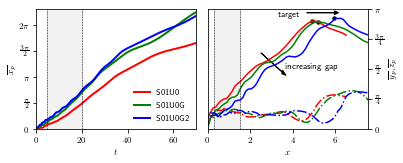

In [5]:
###################################################################################################
################### FIGURE 5: MEAN y_p & z_p vs. t: ST01 & ST1 GAP VS. NO GAP #####################
###################################################################################################

fig, (ax1, ax2) = plt.subplots(1,2, figsize=set_fig(width,sidebyside=3))

ax1.fill_between([5,20],[10,10],
                 facecolor='grey', #fill color
                 color='grey', #outline color
                 alpha=0.1) #fill transparency
ax2.fill_between([time_vs_pos[masterDict[cases[0]]](5),time_vs_pos[masterDict[cases[0]]](20)],[10,10],
                 facecolor='grey', #fill color
                 color='grey', #outline color
                 alpha=0.1) #fill transparency

cases=['S01U0','S01U0G','S01U0G2']
for jj,case in enumerate(cases):
  ii=masterDict[case]
  ax1.plot(time, mpos[Xc,:,ii], colorList[jj],linestyle=lineList[jj], lw = 2, label=case)
  
ax1.axvline(x=5, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax1.axvline(x=20, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$\overline{x_p}$')
ax1.set_xlim(0,time[350])
ax1.set_ylim(0,2.3*math.pi)
ax1.set_yticks([0, math.pi/2, math.pi, 3*math.pi/2, 2*math.pi])
ax1.set_yticklabels([r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])

for jj,case in enumerate(cases):
  ii=masterDict[case]
  ax2.plot(bins, mpos_space[Yc,:,ii], colorList[jj],linestyle=lineList[jj], lw = 1.5, label=case)
  ax2.plot(bins, mpos_space[Zc,:,ii], colorList[jj],linestyle='-.', lw = 1.5)
  ax2.yaxis.set_label_position("right")
  ax2.yaxis.tick_right()

  jj=np.nanargmax(mpos_space[Yc,:,ii])
  ax2.scatter(mpos_space[Xc,jj,ii],mpos_space[Yc,jj,ii],c='k',s=11)
    
ax2.axvline(x=time_vs_pos[masterDict[cases[0]]](5), ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax2.axvline(x=time_vs_pos[masterDict[cases[0]]](20), ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$\overline{y_p}$,$\overline{z_p}$')
ax2.set_xlim(0,2.4*math.pi)
ax2.set_ylim(0,math.pi)
ax2.set_yticks([0, math.pi/4, math.pi/2, 3*math.pi/4, math.pi])
ax2.set_yticklabels([r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])
ax2.arrow(4.65, 3.05, 1.3, 0,head_width=0.1, head_length=0.2, fc='k', ec='k')
ax2.text(3.3,2.95,'target')
ax2.arrow(2.5, 2, 1., -0.5,head_width=0.1, head_length=0.2, fc='k', ec='k')
ax2.text(3.65,1.6,'increasing gap')
ax1.legend(frameon=False)
plt.tight_layout()
plt.savefig('figure_05.pdf')
plt.show()

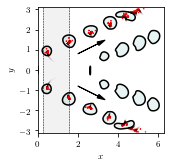

In [6]:
##################################################################
################### CONTOUR SCATTER FOR ST01 #####################
##################################################################
##############################################################
############ EXTRACTING .PICKLE DATA & CALCULATING L2 ############
##################################################################
mycase = 'S01U0'
pickle_in=open('st01_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()


save_flowfield_times = [10,20,30,40,50,60,70]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

z = data['x']
y = data['y']
x = data['z']+correct_x

L2 = data['L2']

##################################
############ PLOTTING ############
##################################
Y, X = np.meshgrid(y, x)
plt.figure(figsize=set_fig(0.4*width,sidebyside=1.2))
plt.axis('equal')
plt.fill_between([time_vs_pos[masterDict[cases[0]]](5),time_vs_pos[masterDict[cases[0]]](20)],[3.3,3.3],y2=[-3.3],
                 facecolor='grey', #fill color
                 color='grey', #outline color
                 alpha=0.1) #fill transparency
plt.axvline(x=time_vs_pos[masterDict[cases[0]]](5), ymin=-3.3, ymax=3.3, c = 'k', ls = '--', lw = 0.5)
plt.axvline(x=time_vs_pos[masterDict[cases[0]]](20), ymin=-3.3, ymax=3.3, c = 'k', ls = '--', lw = 0.5)
for ii in range(len(save_flowfield_times)):
  plt.contour(X,Y,L2[:,:,1,ii],[-0.02], colors = 'black', linestyles = 'solid')
  plt.contourf(X,Y,L2[:,:,1,ii],levels=[-10,-0.02],extend="neither",alpha=0.1)
save_flowfield_snaps = np.zeros(len(save_flowfield_times))

for i in range(len(save_flowfield_times)):
    save_flowfield_snaps[i] = save_flowfield_times[i]/0.2

    
    
for ii,time in enumerate(save_flowfield_times):
   psnap=int(time*5)  #Note for time indexing: 1 index = 0.2 seconds, i.e. index of 50 corresponds to 10 seconds
   zpoints=pos[Zc,:,psnap,masterDict[mycase]]
   select= np.where(abs(zpoints)<10.15)
   alphas = ( np.max(zpoints)-zpoints)/(np.max(zpoints)-np.min(zpoints))
   rgba_colors = np.zeros((len(select[0]),4))
   # for red the first column needs to be one
   rgba_colors[:,0] = (alphas)
   #rgba_colors[:, 2] = (1-alphas)
   # the fourth column needs to be your alphas
   rgba_colors[:, 3] = alphas**3

   plt.scatter(pos[Xc,select,psnap,masterDict[mycase]][0],pos[Yc,select,psnap,masterDict[mycase]][0],marker='^',c=rgba_colors,s=0.5)
   #plt.scatter(np.mean(pos[Xc,select,psnap,masterDict[mycase]]),np.mean(abs(pos[Yc,select,psnap,masterDict[mycase]])))
   #plt.scatter(np.mean(pos[Xc,select,psnap,masterDict[mycase]]),-np.mean(abs(pos[Yc,select,psnap,masterDict[mycase]])))
plt.arrow(2, 0.8, 1., 0.5,head_width=0.2, head_length=0.4, fc='k', ec='k')
plt.arrow(2, -0.8, 1., -0.5,head_width=0.2, head_length=0.4, fc='k', ec='k')
plt.xlim(0,2*np.pi)
plt.ylim(-np.pi,np.pi)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.savefig('figure_03a.pdf',bbox_inches='tight')
plt.show()

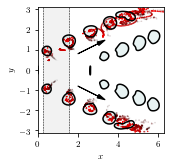

In [7]:
##################################################################
################### CONTOUR SCATTER FOR ST1 #####################
##################################################################
##############################################################
############ EXTRACTING .PICKLE DATA & CALCULATING L2 ############
##################################################################
mycase = 'S1U0'
pickle_in=open('st1_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()


save_flowfield_times = [10,20,30,40,50,60,70]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

z = data['x']
y = data['y']
x = data['z']+correct_x

L2 = data['L2']

##################################
############ PLOTTING ############
##################################
Y, X = np.meshgrid(y, x)
plt.figure(figsize=set_fig(0.4*width,sidebyside=1.2))
plt.axis('equal')
plt.fill_between([time_vs_pos[masterDict[cases[0]]](5),time_vs_pos[masterDict[cases[0]]](20)],[3.3,3.3],y2=[-3.3],
                 facecolor='grey', #fill color
                 color='grey', #outline color
                 alpha=0.1) #fill transparency
plt.axvline(x=time_vs_pos[masterDict[cases[0]]](5), ymin=-3.3, ymax=3.3, c = 'k', ls = '--', lw = 0.5)
plt.axvline(x=time_vs_pos[masterDict[cases[0]]](20), ymin=-3.3, ymax=3.3, c = 'k', ls = '--', lw = 0.5)
for ii in range(len(save_flowfield_times)):
  plt.contour(X,Y,L2[:,:,1,ii],[-0.02], colors = 'black', linestyles = 'solid')
  plt.contourf(X,Y,L2[:,:,1,ii],levels=[-10,-0.02],extend="neither",alpha=0.1)
save_flowfield_snaps = np.zeros(len(save_flowfield_times))

for i in range(len(save_flowfield_times)):
    save_flowfield_snaps[i] = save_flowfield_times[i]/0.2

    
    
for ii,time in enumerate(save_flowfield_times):
   psnap=int(time*5)  #Note for time indexing: 1 index = 0.2 seconds, i.e. index of 50 corresponds to 10 seconds
   zpoints=pos[Zc,:,psnap,masterDict[mycase]]
   select= np.where(abs(zpoints)<10.15)
   alphas = ( np.max(zpoints)-zpoints)/(np.max(zpoints)-np.min(zpoints))
   rgba_colors = np.zeros((len(select[0]),4))
   # for red the first column needs to be one
   rgba_colors[:,0] = (alphas)
   #rgba_colors[:, 2] = (1-alphas)
   # the fourth column needs to be your alphas
   rgba_colors[:, 3] = alphas**2

   plt.scatter(pos[Xc,select,psnap,masterDict[mycase]][0],pos[Yc,select,psnap,masterDict[mycase]][0],marker='^',c=rgba_colors,s=0.5)
   #plt.scatter(np.mean(pos[Xc,select,psnap,masterDict[mycase]]),np.mean(abs(pos[Yc,select,psnap,masterDict[mycase]])))
   #plt.scatter(np.mean(pos[Xc,select,psnap,masterDict[mycase]]),-np.mean(abs(pos[Yc,select,psnap,masterDict[mycase]])))
plt.arrow(2, 0.8, 1., 0.5,head_width=0.2, head_length=0.4, fc='k', ec='k')
plt.arrow(2, -0.8, 1., -0.5,head_width=0.2, head_length=0.4, fc='k', ec='k')
plt.xlim(0,2*np.pi)
plt.ylim(-np.pi,np.pi)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.savefig('figure_03b.pdf',bbox_inches='tight')
plt.show()

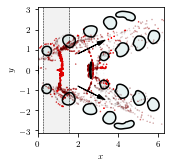

In [8]:
##################################################################
################### CONTOUR SCATTER FOR ST01 #####################
##################################################################
##############################################################
############ EXTRACTING .PICKLE DATA & CALCULATING L2 ############
##################################################################
mycase = 'S10U0'
pickle_in=open('st10_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()


save_flowfield_times = [10,20,30,40,50,60,70]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

z = data['x']
y = data['y']
x = data['z']+correct_x

L2 = data['L2']

##################################
############ PLOTTING ############
##################################
Y, X = np.meshgrid(y, x)
plt.figure(figsize=set_fig(0.4*width,sidebyside=1.2))
plt.axis('equal')
plt.fill_between([time_vs_pos[masterDict[cases[0]]](5),time_vs_pos[masterDict[cases[0]]](20)],[3.3,3.3],y2=[-3.3],
                 facecolor='grey', #fill color
                 color='grey', #outline color
                 alpha=0.1) #fill transparency
plt.axvline(x=time_vs_pos[masterDict[cases[0]]](5), ymin=-3.3, ymax=3.3, c = 'k', ls = '--', lw = 0.5)
plt.axvline(x=time_vs_pos[masterDict[cases[0]]](20), ymin=-3.3, ymax=3.3, c = 'k', ls = '--', lw = 0.5)
for ii in range(len(save_flowfield_times)):
  plt.contour(X,Y,L2[:,:,1,ii],[-0.02], colors = 'black', linestyles = 'solid')
  plt.contourf(X,Y,L2[:,:,1,ii],levels=[-10,-0.02],extend="neither",alpha=0.1)
save_flowfield_snaps = np.zeros(len(save_flowfield_times))

for i in range(len(save_flowfield_times)):
    save_flowfield_snaps[i] = save_flowfield_times[i]/0.2

    
    
for ii,time in enumerate(save_flowfield_times):
   psnap=int(time*5)  #Note for time indexing: 1 index = 0.2 seconds, i.e. index of 50 corresponds to 10 seconds
   zpoints=pos[Zc,:,psnap,masterDict[mycase]]
   select= np.where(abs(zpoints)<10.15)
   alphas = ( np.max(zpoints)-zpoints)/(np.max(zpoints)-np.min(zpoints))
   rgba_colors = np.zeros((len(select[0]),4))
   # for red the first column needs to be one
   rgba_colors[:,0] = (alphas)
   #rgba_colors[:, 2] = (1-alphas)
   # the fourth column needs to be your alphas
   rgba_colors[:, 3] = alphas**2

   plt.scatter(pos[Xc,select,psnap,masterDict[mycase]][0],pos[Yc,select,psnap,masterDict[mycase]][0],marker='^',c=rgba_colors,s=0.5)
   #plt.scatter(np.mean(pos[Xc,select,psnap,masterDict[mycase]]),np.mean(abs(pos[Yc,select,psnap,masterDict[mycase]])))
   #plt.scatter(np.mean(pos[Xc,select,psnap,masterDict[mycase]]),-np.mean(abs(pos[Yc,select,psnap,masterDict[mycase]])))
plt.arrow(2, 0.8, 1., 0.5,head_width=0.2, head_length=0.4, fc='k', ec='k')
plt.arrow(2, -0.8, 1., -0.5,head_width=0.2, head_length=0.4, fc='k', ec='k')
plt.xlim(0,2*np.pi)
plt.ylim(-np.pi,np.pi)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.savefig('figure_03c.pdf',bbox_inches='tight')
plt.show()

NameError: name 'part_zp' is not defined

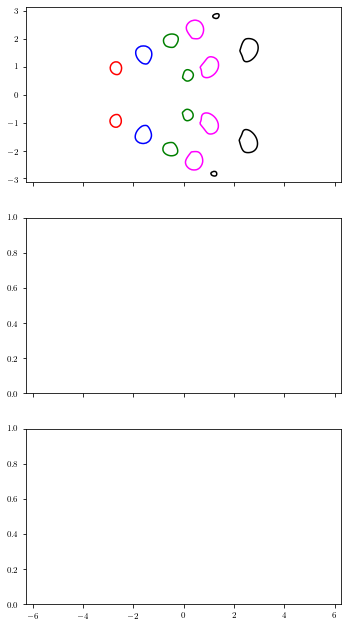

In [9]:
####################################################################
################### FIGURE 3: CONTOUR SCATTER ######################
####################################################################

#######################################
############ FIGURE SIZING ############
#######################################

fraction = 1
# Width of figure
fig_width_pt = width * fraction
# Convert from pt to inches
inches_per_pt = 1 / 72.27
# Golden ratio to set aesthetic figure height
golden_ratio = (5**.5 - 1) / 2
# Figure width in inches
fig_width_in = fig_width_pt * inches_per_pt
# Figure height in inches
fig_height_in = fig_width_in * golden_ratio * 3 + 0.5
fig_dim = (fig_width_in, fig_height_in)

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize = fig_dim)

##############################
############ ST01 ############
##############################
from lambda2 import *

pickle_in=open('st01_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

save_flowfield_times = [0,10,20,30,40,50,60]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

x = data['x']
y = data['y']
z = data['z']

for n in range(len(save_flowfield_times)):
    for k in range(512):
        for j in range(256):
            for i in range(3):
                L2[k,j,i,n] = data['L2'][k,j,i,n]

Y, Z = np.meshgrid(y, z)

ax1.contour(Z,Y,L2[:,:,1,1],[-0.05], colors = 'red', linestyles = 'solid')
ax1.contour(Z,Y,L2[:,:,1,2],[-0.005], colors = 'blue', linestyles = 'solid')
ax1.contour(Z,Y,L2[:,:,1,3],[-0.05], colors = 'green', linestyles = 'solid')
ax1.contour(Z,Y,L2[:,:,1,4],[-0.005], colors = 'magenta', linestyles = 'solid')
ax1.contour(Z,Y,L2[:,:,1,6],[-0.005], colors = 'black', linestyles = 'solid')

ax1.scatter(part_zp[:,50,0],part_yp[:,50,0], s = 0.25, color = 'red')
ax1.scatter(part_zp[:,100,0],part_yp[:,100,0], s = 0.25, color = 'blue')
ax1.scatter(part_zp[:,150,0],part_yp[:,150,0], s = 0.25, color = 'green')
ax1.scatter(part_zp[:,200,0],part_yp[:,200,0], s = 0.25, color = 'magenta')
ax1.scatter(part_zp[:,300,0],part_yp[:,300,0], s = 0.25, color = 'black')

ax1.set_ylabel(r'$y$')
ax1.set_xlim(-math.pi,math.pi)
ax1.set_ylim(-math.pi,math.pi)

ax1.set_yticks([-math.pi,-math.pi/2,0,math.pi/2,math.pi])
ax1.set_yticklabels([r'$-\pi$', r'$\frac{-\pi}{2}$', r'0', r'$\frac{\pi}{2}$', r'$\pi$'])

from matplotlib.offsetbox import AnchoredText
anchored_text = AnchoredText('$St = 0.1$', loc=2)
ax1.add_artist(anchored_text)

##############################
############ ST1 #############
##############################
from lambda2 import *

pickle_in=open('st1_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

save_flowfield_times = [0,10,20,30,40,50,60]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

x = data['x']
y = data['y']
z = data['z']

for n in range(len(save_flowfield_times)):
    for k in range(512):
        for j in range(256):
            for i in range(3):
                L2[k,j,i,n] = data['L2'][k,j,i,n]

Y, Z = np.meshgrid(y, z)

ax2.contour(Z,Y,L2[:,:,1,1],[-0.05], colors = 'red', linestyles = 'solid')
ax2.contour(Z,Y,L2[:,:,1,2],[-0.005], colors = 'blue', linestyles = 'solid')
ax2.contour(Z,Y,L2[:,:,1,3],[-0.05], colors = 'green', linestyles = 'solid')
ax2.contour(Z,Y,L2[:,:,1,4],[-0.005], colors = 'magenta', linestyles = 'solid')
ax2.contour(Z,Y,L2[:,:,1,6],[-0.005], colors = 'black', linestyles = 'solid')

ax2.scatter(part_zp[:,50,1],part_yp[:,50,1], s = 0.25, color = 'red')
ax2.scatter(part_zp[:,100,1],part_yp[:,100,1], s = 0.25, color = 'blue')
ax2.scatter(part_zp[:,150,1],part_yp[:,150,1], s = 0.25, color = 'green')
ax2.scatter(part_zp[:,200,1],part_yp[:,200,1], s = 0.25, color = 'magenta')
ax2.scatter(part_zp[:,300,1],part_yp[:,300,1], s = 0.25, color = 'black')

ax2.set_ylabel(r'$y$')
ax2.set_xlim(-math.pi,math.pi)
ax2.set_ylim(-math.pi,math.pi)

ax2.set_yticks([-math.pi,-math.pi/2,0,math.pi/2,math.pi])
ax2.set_yticklabels([r'$-\pi$', r'$\frac{-\pi}{2}$', r'0', r'$\frac{\pi}{2}$', r'$\pi$'])

from matplotlib.offsetbox import AnchoredText
anchored_text = AnchoredText('$St = 1$', loc=2)
ax2.add_artist(anchored_text)

##############################
############ ST10 ############
##############################

from lambda2 import *

pickle_in=open('st10_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

save_flowfield_times = [0,10,20,30,40,50,60]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

x = data['x']
y = data['y']
z = data['z']

for n in range(len(save_flowfield_times)):
    for k in range(512):
        for j in range(256):
            for i in range(3):
                L2[k,j,i,n] = data['L2'][k,j,i,n]

Y, Z = np.meshgrid(y, z)

ax3.contour(Z,Y,L2[:,:,1,1],[-0.05], colors = 'red', linestyles = 'solid')
ax3.contour(Z,Y,L2[:,:,1,3],[-0.05], colors = 'green', linestyles = 'solid')
ax3.contour(Z,Y,L2[:,:,1,6],[-0.005], colors = 'black', linestyles = 'solid')

ax3.scatter(part_zp[:,50,2],part_yp[:,50,2], s = 0.25, color = 'red')
ax3.scatter(part_zp[:,150,2],part_yp[:,150,2], s = 0.25, color = 'green')
ax3.scatter(part_zp[:,300,2],part_yp[:,300,2], s = 0.25, color = 'black')

ax3.set_xlabel(r'$x$')
ax3.set_ylabel(r'$y$')
ax3.set_xlim(-math.pi,math.pi)
ax3.set_ylim(-math.pi,math.pi)

ax3.set_yticks([-math.pi,-math.pi/2,0,math.pi/2,math.pi])
ax3.set_yticklabels([r'$-\pi$', r'$\frac{-\pi}{2}$', r'0', r'$\frac{\pi}{2}$', r'$\pi$'])

ax3.set_xticks([-math.pi,-math.pi/2,0,math.pi/2,math.pi])
ax3.set_xticklabels([r'0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])

from matplotlib.offsetbox import AnchoredText
anchored_text = AnchoredText('$St = 10$', loc=2)
ax3.add_artist(anchored_text)

from matplotlib.lines import Line2D
colors = ['red', 'blue', 'green', 'magenta', 'black']
lines = [Line2D([0], [0], color=c, linewidth=1, linestyle='-') for c in colors]
labels = ['10', '20', '30','40','60']

plt.legend(lines,labels,loc='upper center', bbox_to_anchor=(0.5, -0.35),
          ncol=5, title = '$t$', fancybox=False, shadow=False, framealpha = 1, edgecolor = '0')

plt.savefig('st01_st1_st10_scatter_isosurfaces.pdf',bbox_inches='tight')